In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
def load_change_events(change_events_file):
    """
    Load the change events from a JSON file.
    """
    if not os.path.exists(change_events_file):
        raise FileNotFoundError(f"{change_events_file} does not exist")
    with open(change_events_file, 'r') as f:
        events = json.load(f)
    return events

def extract_features(events):
    """
    Convert the change events into a feature matrix.
    This example assumes each event contains an "object_id".
    The features include:
      - Change magnitude statistics (mean, std, min, max, median, quant90, quant95, quant99)
      - Convex hull properties (hull surface area, volume, and ratio)
      - Geometric features from both epochs
    """
    rows = []
    for event in events:
        row = {}
        # Change magnitude statistics
        change_mags = event.get('change_magnitudes', {})
        for stat in ['mean', 'std', 'min', 'max', 'median', 'quant90', 'quant95', 'quant99']:
            row[f'change_{stat}'] = change_mags.get(stat, np.nan)
        
        # Convex hull properties
        convex_hull = event.get('convex_hull', {})
        row['hull_surface_area'] = convex_hull.get('surface_area', np.nan)
        row['hull_volume'] = convex_hull.get('volume', np.nan)
        row['hull_surf_vol_ratio'] = convex_hull.get('surface_area_to_volume_ratio', np.nan)
        
        # Geometric features from both epochs (if available)
        geom = event.get('geometric_features_both_epochs', {})
        for feat in ['sum_of_eigenvalues', 'omnivariance', 'eigentropy', 'anisotropy',
                     'planarity', 'linearity', 'surface_variation', 'sphericity', 'verticality']:
            row[f'geom_{feat}'] = geom.get(feat, np.nan)
        
        # Unique identifier and event type (if provided)
        row['object_id'] = event.get('object_id')
        row["event_type"] = event.get('event_type', np.nan)
        
        rows.append(row)
    df = pd.DataFrame(rows)
    return df

def filter_event(row, rules):
    """
    Filter an event based on a set of rule conditions.
    
    If the event is already classified—that is, if the 'classification' key exists 
    and is not "unclassified"—then the row is kept as is.
    
    Otherwise, the function checks the rules (a dictionary structured as follows):
    
      rules = {
          "label_name": {
              "feature1": {"min": value, "max": value},
              "feature2": {"min": value},
              ...
          },
          ... 
      }
      
    For each label, the event meets the criteria if, for every specified feature:
       - The feature's value is not NaN.
       - If a "min" is specified, the value is >= min.
       - If a "max" is specified, the value is <= max.
       
    If any rule is satisfied, the function sets the event's classification to that label 
    and returns True (meaning the event should be kept).
    
    If no rules apply, the function returns False so that the row can be removed.
    
    Returns:
        bool: True if the event is classified (or already had a classification) and should 
              be kept, False otherwise.
    """
    # If the row already carries a valid classification, preserve it.
    if row.get('classification', 'unclassified') != 'unclassified':
        return True
    
    # Check each rule.
    for label, conditions in rules.items():
        meets_conditions = True
        for feature, thresholds in conditions.items():
            value = row.get(feature, np.nan)
            if pd.isna(value):
                meets_conditions = False
                break
            if "min" in thresholds and value < thresholds["min"]:
                meets_conditions = False
                break
            if "max" in thresholds and value > thresholds["max"]:
                meets_conditions = False
                break
        if meets_conditions:
            # Assign the new classification.
            row['classification'] = label
            return True
            
    # If no conditions are met, return False (event will be filtered out).
    return False

### Define rules

In [18]:
# Define a dictionary for rule-based filtering.
# All filters are applied sequentially and combined with OR logic.

filter_rules = {
    "first_filter": {
         "change_mean": {"min": 0.2, "max": 10},
         "hull_volume": {"min": 100}
    },
    "second_filter": {
         "change_mean": {"max": 0.2}
    },
    "third_filter": {
         "change_mean": {"min": 1, "max": 5},
         "hull_volume": {"min": 5, "max": 10}
    },
}


### Load the data

In [8]:
# Set current directory to the location of the notebook (works even if __file__ is not defined)
try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()

os.chdir(current_dir)

# Path to the unlabelled change events test file
change_events_file = "../test_data/change_events_unlabelled.json"
filtered_file = os.path.join(os.path.dirname(change_events_file), 'change_events_filtered_rule_based.json')

# Load the change events
events = load_change_events(change_events_file)

### Extract features from the events

In [9]:
# Extract features into a DataFrame
features_df = extract_features(events)

In [ ]:
features_df = features_df[features_df.apply(lambda row: filter_event(row, filter_rules), axis=1)]

### Save clustered change events

In [11]:
# Create a mapping from object_id to the chosen cluster label (event_type)
label_mapping = dict(zip(features_df['object_id'], features_df['event_type']))

# Update the original events by matching them by object_id.
for event in events:
    obj_id = event.get('object_id')
    if obj_id in label_mapping:
        event['event_type'] = label_mapping[obj_id]
    else:
        # Mark events dropped due to missing features as None
        event['event_type'] = None

# Save the updated events to a new JSON file.
with open(filtered_file, 'w') as f:
    json.dump(events, f, indent=4)

### Visualize remaining data

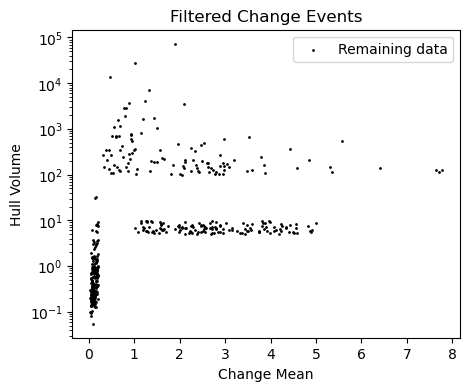

In [17]:
plt.figure(figsize=(5, 4))
plt.scatter(features_df['change_mean'], features_df['hull_volume'], label='Remaining data', s=1, color = 'black')

plt.yscale('log')
plt.legend()
plt.xlabel('Change Mean')
plt.ylabel('Hull Volume')
plt.title('Filtered Change Events')
plt.show()